# Running/Importing .py files with Colab  

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Access my google drive

Install Keras

In [7]:
!pip install -q keras

# Get the Class Names

Below file contains a subset of the quick draw classes (around 100 classes)

In [8]:
!wget 'https://raw.githubusercontent.com/clh7782/tfjs_sketcher/master/mini_classes.txt'

--2023-07-30 12:09:42--  https://raw.githubusercontent.com/clh7782/tfjs_sketcher/master/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 860 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     860  --.-KB/s    in 0s      

2023-07-30 12:09:43 (39.8 MB/s) - ‘mini_classes.txt’ saved [860/860]



Read the class names


In [9]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [10]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the dataset

Loop over the classes and download correspondent data

In [11]:
!mkdir data

In [12]:
import urllib.request
def download():

  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [13]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports

In [14]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the data

Load 5000 images per class

In [15]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 5000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [16]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [17]:
print(len(x_train))

400000


broom


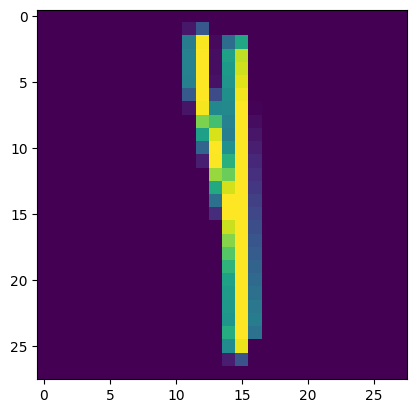

In [18]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the data

In [19]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

In [20]:
# Define model
model = keras.Sequential()
x = layers.Convolution2D(128, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu')
model.add(x)
model.add(layers.BatchNormalization())

for size in [256, 512, 728]:
  model.add(layers.SeparableConv2D(size, (3, 3), padding='same', activation= 'relu'))
  model.add(layers.BatchNormalization())

  model.add(layers.SeparableConv2D(size, (3, 3), padding='same', activation= 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(3, strides=2, padding="same"))


model.add(layers.SeparableConv2D(1024, (3, 3), padding="same", activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 separable_conv2d (Separable  (None, 28, 28, 256)      34176     
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 256)      1024      
 hNormalization)                                                 
                                                                 
 separable_conv2d_1 (Separab  (None, 28, 28, 256)      68096     
 leConv2D)                                              

In [21]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(128, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.SeparableConv2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.SeparableConv2D(512, (3, 3), padding='same', activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size =(2,2)))

model.add(layers.SeparableConv2D(728, (3, 3), padding='same', activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size =(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 separable_conv2d_7 (Separab  (None, 14, 14, 256)      34176     
 leConv2D)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                  

# Training

In [22]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=10)

Epoch 1/10
1407/1407 - 63s - loss: 1.1776 - top_k_categorical_accuracy: 0.8927 - val_loss: 0.9378 - val_top_k_categorical_accuracy: 0.9261 - 63s/epoch - 45ms/step
Epoch 2/10
1407/1407 - 49s - loss: 0.7793 - top_k_categorical_accuracy: 0.9415 - val_loss: 0.8816 - val_top_k_categorical_accuracy: 0.9334 - 49s/epoch - 35ms/step
Epoch 3/10
1407/1407 - 48s - loss: 0.6728 - top_k_categorical_accuracy: 0.9514 - val_loss: 0.7922 - val_top_k_categorical_accuracy: 0.9388 - 48s/epoch - 34ms/step
Epoch 4/10
1407/1407 - 50s - loss: 0.6002 - top_k_categorical_accuracy: 0.9583 - val_loss: 0.7488 - val_top_k_categorical_accuracy: 0.9440 - 50s/epoch - 35ms/step
Epoch 5/10
1407/1407 - 48s - loss: 0.5383 - top_k_categorical_accuracy: 0.9638 - val_loss: 0.7595 - val_top_k_categorical_accuracy: 0.9423 - 48s/epoch - 34ms/step
Epoch 6/10
1407/1407 - 50s - loss: 0.4819 - top_k_categorical_accuracy: 0.9694 - val_loss: 0.7906 - val_top_k_categorical_accuracy: 0.9419 - 50s/epoch - 36ms/step
Epoch 7/10
1407/1407 -

# Testing

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.67%


# Inference

1/1 [==============================] - 0s 239ms/step
['helmet', 'bread', 'diving_board', 'key', 'beard']


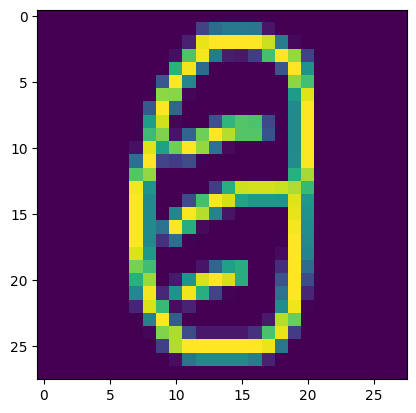

In [24]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the Classes

In [25]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [26]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 46.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Suc

# Save and Convert

In [27]:
model.save('keras.h5')

In [28]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2023-07-30 12:25:40.175771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Zip and Download

In [29]:
!cp class_names.txt model/class_names.txt

In [30]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 87%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/class_names.txt (deflated 41%)


In [31]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>